In [7]:
# %% [markdown]
# # Notebook : MLP – Apprentissage croisé sur bid-ask spread

# %%  --------------------------------------------------------------------
# 0. Imports et paramètres globaux
# -----------------------------------------------------------------------
import os, sys, numpy as np, pandas as pd, tensorflow as tf, keras
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from data.DataManager import DataManager
from dl_models.MLPs   import create_mlp_model           # ton utilitaire existant

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Paramètres des actifs / périodes
train_assets = ["TRXUSDT", "MATICUSDT"]
train_year, train_month = 2023, 9

test_assets  = ["SOLUSDT", "XRPUSDT"]
test_year, test_month  = 2023,10     # autre mois




In [13]:
# %% --------------------------------------------------------------------
# 1. Préparation des données d'entraînement
# -----------------------------------------------------------------------
dm_train = DataManager(train_assets, train_year, train_month, light=True)
dm_train.download_and_prepare_data()                   # zip → parquet
dm_train.build_features(daily=True, serial_dependency=False)
dm_train.build_labels()

X_train_raw, y_train_raw = dm_train.build_training_data(
    daily=True, serial_dependency=False
)

# pas besoin de split temporel : on veut tout pour l'entraînement
# normalisation
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train_raw)
y_train = scaler_y.fit_transform(y_train_raw.reshape(-1,1)).flatten()

# reshape en (batch, seq_len, input_dim)  -> seq_len=1 au pas "daily"
seq_len, input_dim = 1, X_train.shape[1]
X_train = X_train.reshape(-1, seq_len, input_dim)

print("Train :", X_train.shape, y_train.shape)

⚠️ Klines déjà existant : c:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\raw data\TRXUSDT-1m-2023-09.parquet
⚠️ BookTicker déjà existant : c:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\raw data\TRXUSDT-bookTicker-2023-09.parquet
⚠️ Klines déjà existant : c:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\raw data\MATICUSDT-1m-2023-09.parquet
⚠️ BookTicker déjà existant : c:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\raw data\MATICUSDT-bookTicker-2023-09.parquet
✅ Fichier déjà existant, ignoré : c:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\daily features data\TRXUSDT-1m-2023-09_features_False.parquet
✅ Fichier déjà existant, ignoré : c:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\daily features data\MATICUSDT-1m-2023-09_features_False.parquet
✅ Fichier déjà existant, ignoré 

In [14]:
# %% --------------------------------------------------------------------
# 2. Préparation des données de test
# -----------------------------------------------------------------------
dm_test = DataManager(test_assets, test_year, test_month, light=True)
dm_test.download_and_prepare_data()
dm_test.build_features(daily=True,serial_dependency=False)
dm_test.build_labels()

X_test_raw, y_test_raw = dm_test.build_training_data(daily=True, serial_dependency=False)
    

X_test  = scaler_X.transform(X_test_raw)
y_test  = scaler_y.transform(y_test_raw.reshape(-1,1)).flatten()
X_test  = X_test.reshape(-1, seq_len, input_dim)




⚠️ Klines déjà existant : c:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\raw data\SOLUSDT-1m-2023-10.parquet
⚠️ BookTicker déjà existant : c:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\raw data\SOLUSDT-bookTicker-2023-10.parquet
⚠️ Klines déjà existant : c:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\raw data\XRPUSDT-1m-2023-10.parquet
⚠️ BookTicker déjà existant : c:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\raw data\XRPUSDT-bookTicker-2023-10.parquet
✅ Fichier déjà existant, ignoré : c:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\daily features data\SOLUSDT-1m-2023-10_features_False.parquet
✅ Fichier déjà existant, ignoré : c:\Users\theod\OneDrive\Documents\GitHub\Deep-Learning-for-Spread-Forecasting\data\daily features data\XRPUSDT-1m-2023-10_features_False.parquet
✅ Fichier déjà existant, ignoré : c:\U

In [18]:
# %% --------------------------------------------------------------------
# 3. Création et entraînement du MLP
# -----------------------------------------------------------------------
model = create_mlp_model(
    input_shape=(seq_len, input_dim),
    model_type="simple",          # ou "residual"
    hidden_dims=[128, 64, 32]
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    #callbacks=[keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)]
                                             
)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 2.2253 - val_loss: 0.0369
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 1.9522 - val_loss: 0.0568
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.7833 - val_loss: 0.0796
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.6587 - val_loss: 0.1015
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.5551 - val_loss: 0.1210
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 1.4642 - val_loss: 0.1396
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 1.3787 - val_loss: 0.1590
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 1.2964 - val_loss: 0.1789
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 1.2171 - val_loss: 0.1997
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 1.1422 - val_loss: 0.2229
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 1.0740 - val_loss: 0.2475
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 1.0122 - val_l

In [19]:
# %% --------------------------------------------------------------------
# 4. Évaluation sur l'ensemble de test
# -----------------------------------------------------------------------
y_pred_norm = model.predict(X_test).flatten()
y_pred      = scaler_y.inverse_transform(y_pred_norm.reshape(-1,1)).flatten()
y_true      = scaler_y.inverse_transform(y_test.reshape(-1,1)).flatten()

r2   = r2_score(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
mae  = mean_absolute_error(y_true, y_pred)

print(f"R²  : {r2:.4f}")
print(f"RMSE: {rmse:.6f} (mêmes unités que le spread)")
print(f"MAE : {mae:.6f}")

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000152037C6160> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
R²  : -1.0313
RMSE: 0.000875 (mêmes unités que le spread)
MAE : 0.000627


c:\Users\theod\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


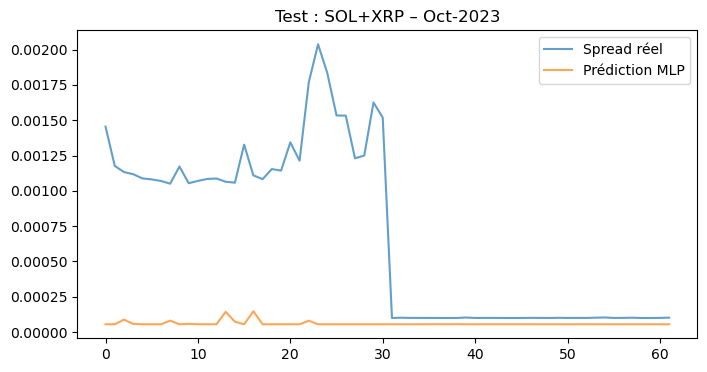

In [20]:
# %% --------------------------------------------------------------------
# 5. Aperçu graphique (optionnel)
# -----------------------------------------------------------------------
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(y_true, label="Spread réel", alpha=0.7)
plt.plot(y_pred, label="Prédiction MLP", alpha=0.7)
plt.title("Test : SOL+XRP – Oct-2023")
plt.legend(); plt.show()